In [52]:
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import datetime as dt
import os
import time

## 1. Load and visualize data

In [2]:
path = r"..."
# read data, parse dates
data = pd.read_csv(os.path.join(path, 'AAPL_20140512_Trades.csv'),header = None,parse_dates = [0,1],infer_datetime_format = True)
# set column names
data.columns = 'Date Time ? Price Volume'.split()
# set index based on time, since all data have same date
data['Time'] = data['Time'].apply(lambda d: d.time())
data.set_index('Time',inplace = True)
data.head(5)

,Date,?,Price,Volume
Time,,,,
04:00:43.070000,2014-05-12,T,586.67,100
04:00:43.073000,2014-05-12,T,586.94,100
04:00:43.074000,2014-05-12,T,587.00,100
04:00:43.074000,2014-05-12,T,587.00,100
04:12:33.221000,2014-05-12,T,586.00,300


We visualize price and volume data using matplotlib. For volume, there are few outliers that may skew the bar chart. Hence we set the limit for bar chart between 0 and 99.9th percentile of the data.

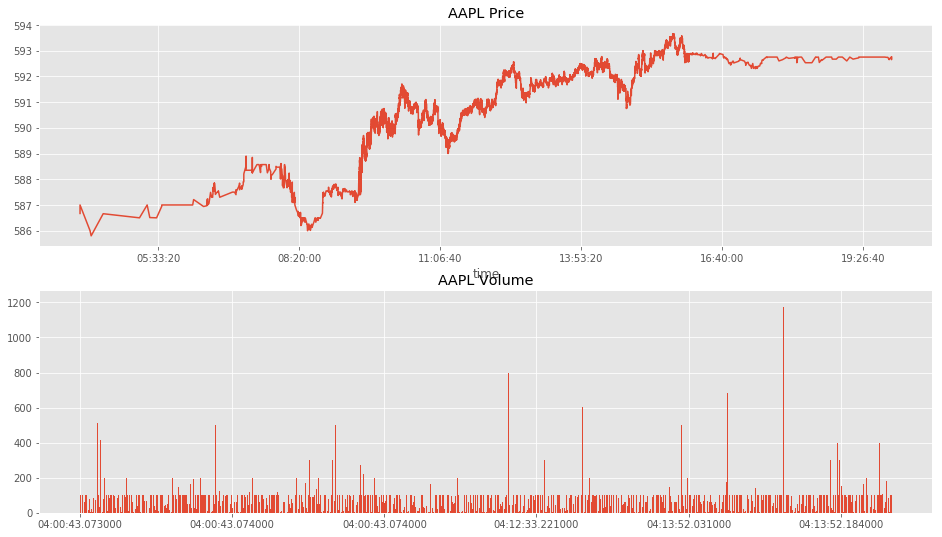

In [41]:
plt.style.use('ggplot')
fig, ax = plt.subplots(nrows = 2, sharex = False, figsize = (16,9))
ax[0].plot(data.index,data.Price)
ax[0].set_title('AAPL Price')
ax[1].bar(range(len(data.index)), height = data.Volume)
ax[1].set_title('AAPL Volume')
ax[1].set_ylim([0,data['Volume'].quantile(0.999)])
ax[1].set_xticklabels(data.index.tolist())
plt.show()

Let's take a look at outliers at Volume.

In [3]:
data[data['Volume'] > data['Volume'].quantile(0.9999)]

,Date,?,Price,Volume
Time,,,,
09:30:00.137000,2014-05-12,T,587.45,57666
09:30:00.137000,2014-05-12,T,587.45,57666
09:34:07.296000,2014-05-12,T,589.00,6000
09:39:35.439000,2014-05-12,T,589.10,5000
10:13:26.490000,2014-05-12,T,590.08,6000
12:53:28.786000,2014-05-12,T,591.75,6089


There are duplicates on the trades occuring at market opening aunction. We will remove this. First we will find the integer index of this timestamp, then we will construct a list of duplicated index at the open and drop if. We then recreate the dataframe to ensure that there is no duplicated values on market open

In [12]:
cleaned_data_df = data.copy(deep = True)
cleaned_data_df.reset_index(inplace = True)
mkt_open_idx_list = cleaned_data_df[cleaned_data_df['Volume'] == cleaned_data_df['Volume'].max()].index.tolist()
cleaned_data_df.drop(mkt_open_idx_list[1:],inplace = True)
cleaned_data_df[cleaned_data_df['Volume'] == cleaned_data_df['Volume'].max()]

,Time,Date,?,Price,Volume
804,09:30:00.137000,2014-05-12,T,587.45,57666


Let's look at distribution of our dataset,

In [5]:
cleaned_data_df.describe()

,Price,Volume
count,53343.000000,53343.000000
mean,591.128244,81.562511
std,1.449366,271.911293
min,585.800000,1.000000
25%,590.110000,25.000000
50%,591.060000,95.000000
75%,592.380000,100.000000
max,593.660000,57666.000000


Moreover, there seems to be a lot of trades occur within one timestamp. We will aggregate them using VWAP, which is defined as following: $$VWAP_i = \frac{\sum{Price_i*Volume_i}}{\sum{Volume_i}} $$ with i is one timestamp. After applying VWAP to aggregate ticks, we have halved the dataframe.

In [13]:
print('Orignal dataframe has {} rows'.format(len(cleaned_data_df)))
# calculate the multiplication of price and volume to calculate VWAP later
cleaned_data_df['PxV'] = cleaned_data_df['Price']*cleaned_data_df['Volume']
print(cleaned_data_df.head(10))
# find duplicated timestamp
dup_ts_boolean= cleaned_data_df.duplicated('Time',keep = False)
# create a list of duplicated timestamp so that later we will calculate VWAP based on this
dup_ts_idx = cleaned_data_df[dup_ts_boolean]['Time'].drop_duplicates().tolist()
# group the dataframe by Time, any rows with the same timestamp will be summed together
cleaned_data_df = cleaned_data_df.groupby('Time').sum()
# now Price is simply VWAP = P*V/V
cleaned_data_df.loc[dup_ts_idx,'Price'] = cleaned_data_df.loc[dup_ts_idx,'PxV']/cleaned_data_df.loc[dup_ts_idx,'Volume']
print('\nNew dataframe has {} rows'.format(len(cleaned_data_df)))
print(cleaned_data_df.head(10))

Orignal dataframe has 53343 rows
              Time       Date  ?   Price  Volume        PxV
0  04:00:43.070000 2014-05-12  T  586.67     100   58667.00
1  04:00:43.073000 2014-05-12  T  586.94     100   58694.00
2  04:00:43.074000 2014-05-12  T  587.00     100   58700.00
3  04:00:43.074000 2014-05-12  T  587.00     100   58700.00
4  04:12:33.221000 2014-05-12  T  586.00     300  175800.00
5  04:13:52.031000 2014-05-12  T  585.80     100   58580.00
6  04:13:52.184000 2014-05-12  T  585.80     100   58580.00
7  04:27:57.408000 2014-05-12  T  586.66     100   58666.00
8  04:27:59.552000 2014-05-12  T  586.66     100   58666.00
9  04:28:05.162000 2014-05-12  T  586.66      43   25226.38

New dataframe has 25658 rows
                  Price  Volume        PxV
Time                                      
04:00:43.070000  586.67     100   58667.00
04:00:43.073000  586.94     100   58694.00
04:00:43.074000  587.00     200  117400.00
04:12:33.221000  586.00     300  175800.00
04:13:52.031000  58

## 2. Calculate tick imbalance bars

### 2.1. Calculate $b_t$ 

Calculate sequence of $b_t$ whereby $b_t$ is calculated as 


\begin{equation}
 b_t=\left\{
  \begin{array}{@{}ll@{}}
    b_{t-1}, & \text{if}\ \Delta p_t = 0 \\
    \frac{|\Delta p_t|}{\Delta p_t}, & \text{if}\ \Delta p_t \neq 0
  \end{array}\right.
\end{equation} 



In [46]:
# create a deep copy from raw data for further manipulation
working_df = cleaned_data_df.copy(deep = True)
# calculate delta price
working_df['Price_Delta'] = working_df['Price'].diff()
# fill first value of Price Delta column with 0
working_df.fillna(0,inplace = True)
# calculate the ratio of abs(price_delta) vs price_delta
working_df['b'] = abs(working_df['Price_Delta'])/working_df['Price_Delta']
working_df.head(5)

,Price,Volume,PxV,Price_Delta,b
Time,,,,,
04:00:43.070000,586.67,100,58667.0,0.00,NaN
04:00:43.073000,586.94,100,58694.0,0.27,1.0
04:00:43.074000,587.00,200,117400.0,0.06,1.0
04:12:33.221000,586.00,300,175800.0,-1.00,-1.0
04:13:52.031000,585.80,100,58580.0,-0.20,-1.0


In [47]:
# following the logic to calculate b_t, we forward fill values to replace NaN
# since NaN are ticks that delta p_t = 0
working_df['b'].ffill(inplace = True)
# assume b0 is equal 1 since we don't have terminal value bT from the immediately prceding bar
working_df.iloc[0,4] = 1
working_df.head(5)

,Price,Volume,PxV,Price_Delta,b
Time,,,,,
04:00:43.070000,586.67,100,58667.0,0.00,1.0
04:00:43.073000,586.94,100,58694.0,0.27,1.0
04:00:43.074000,587.00,200,117400.0,0.06,1.0
04:12:33.221000,586.00,300,175800.0,-1.00,-1.0
04:13:52.031000,585.80,100,58580.0,-0.20,-1.0


### 2.2. Calculate $\theta _T$

Tick imbalance at time $T$ is defined as 
\begin{equation}
    \theta _T = \sum_{t=1}^{T} b_t
\end{equation}

In [48]:
# theta_T is simply cumulative sum of b_t up until time T
working_df['theta'] = working_df['b'].cumsum()
working_df.head(5)

,Price,Volume,PxV,Price_Delta,b,theta
Time,,,,,,
04:00:43.070000,586.67,100,58667.0,0.00,1.0,1.0
04:00:43.073000,586.94,100,58694.0,0.27,1.0,2.0
04:00:43.074000,587.00,200,117400.0,0.06,1.0,3.0
04:12:33.221000,586.00,300,175800.0,-1.00,-1.0,2.0
04:13:52.031000,585.80,100,58580.0,-0.20,-1.0,1.0


### 2.3. Calculate $E_0[T]$ 

Calculate $E_0[\theta _T] = E_0[T](P[b_t = 1] - P[b_t= -1])$ by approximating $$E_0[T] = EMA(T)$$ and $$(P[b_t = 1] - P[b_t= -1]) = (2P[b_t=1] - 1)= EMA(b_t)$$

We will set up a constant variable representing window that we use to calculate the moving average.

We will assign

In [49]:
WINDOW = 2000
# utilizing ewm method in pandas to calculate exponential moving average
# calculate E_0[T] and 2P[b_t=1] -1 based on above formulas
working_df['Pb'] = working_df['b'].ewm(span = WINDOW).mean()
# multiply these two columns to obtain E_0[theta_T]
#working_df['E[theta_T]'] = working_df['E[T]']*working_df['2P(b)-1']
working_df.head(5)

,Price,Volume,PxV,Price_Delta,b,theta,Pb
Time,,,,,,,
04:00:43.070000,586.67,100,58667.0,0.00,1.0,1.0,1.00000
04:00:43.073000,586.94,100,58694.0,0.27,1.0,2.0,1.00000
04:00:43.074000,587.00,200,117400.0,0.06,1.0,3.0,1.00000
04:12:33.221000,586.00,300,175800.0,-1.00,-1.0,2.0,0.49925
04:13:52.031000,585.80,100,58580.0,-0.20,-1.0,1.0,0.19880


After calculating necessary variables, we will calculate tick imbalance bars (TIB) as defined below $$T^* = arg_T min \{|\theta _T| \geq E_0[T]*|P[b_t =1]-1|\} $$

Since we do not know yet $E_0[T]$ at the first tick, we will assign an arbitrary number for it. Then we will upgrate this value once we have new T (number of ticks) when the condition is satisfied.

In [75]:
# TIB is the subset of ticks where |theta_T| >= expected value of theta_T at time T
INITIAL_ET= 75
loop_start = time.time()
working_df['E_T'] = INITIAL_ET
start_idx = working_df.index[0]

tib = list()
T_list = [INITIAL_ET]

for i in working_df.itertuples():
    if abs(i.theta) >= i.E_T*abs(i.Pb):
        # if the condition is satisfied, then we update new tick, calculate new E_t0 using EWMA
        # calculate new tick (number of tick from start_idx to when the condition is satisfied)
        new_T = working_df.loc[start_idx:i.Index].shape[0]
        # add this to a list to construct dataframe of TIB later
        tib.append((start_idx,i.Index,new_T))
        # update start_idx
        start_idx = i.Index
        # add new_T to a list to calculate new E_t0 using EWMA
        T_list.append(new_T)
        T_df = pd.DataFrame(T_list)[0].ewm(span = WINDOW).mean()[len(T_list)-1]
        working_df.loc[i.Index:,'E[T]'] = new_E_T
print(time.time()-loop_start)

161.37764859199524


The loop takes roughly 2.5 minutes to calculate TIB for the whole dataset

In [76]:
tib_df = pd.DataFrame(tib,columns = ['start','end','TIB'])
tib_df.head()

,start,end,TIB
0,04:00:43.070000,07:24:21.067000,76
1,07:24:21.067000,07:24:21.071000,2
2,07:24:21.071000,07:24:22.647000,2
3,07:24:22.647000,07:29:48.138000,2
4,07:29:48.138000,07:30:08.310000,2


Let's look at the distribution of TIB dataframe

In [77]:
tib_df.describe()

,TIB
count,25503.000000
mean,2.006039
std,0.540896
min,2.000000
25%,2.000000
50%,2.000000
75%,2.000000
max,76.000000


## 3. Visualize tick imbalance bars 

First we look at the plot of TIB. In this case, I used line chart instead of bar chart due to some technical issues with Python which prevents me from plotting a neat bar chart with milisecond x-axis.

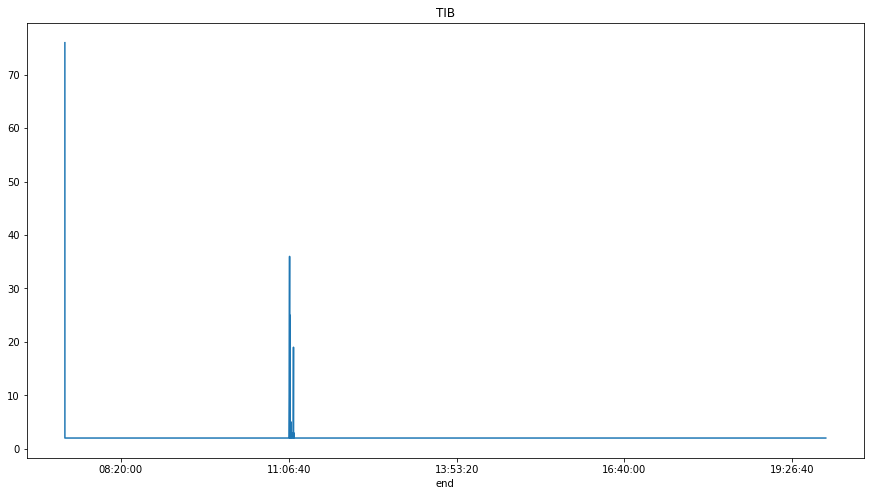

In [78]:
tib_df.set_index('end')['TIB'].plot(figsize = (15,8),title = 'TIB')

From the distribution statistics as well as the chart, we can see that the majority of TIB in this dataset are 2. I am not sure yet whether this is a good thing or not.


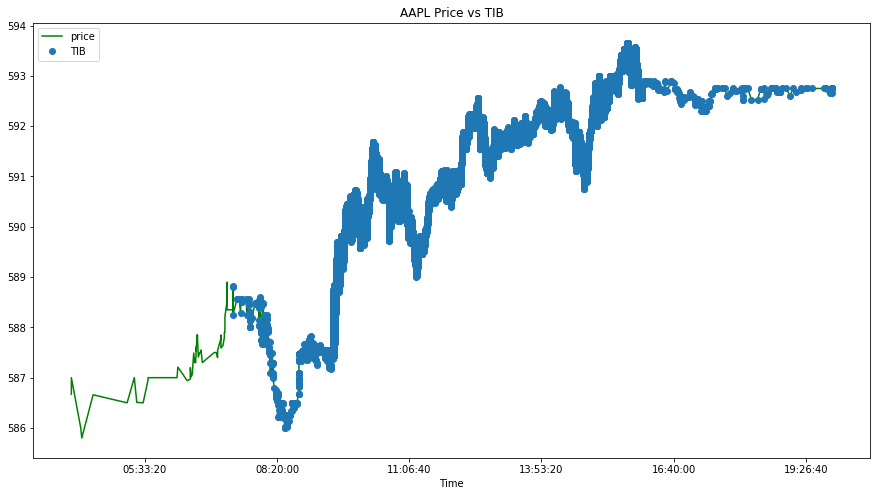

In [79]:
plt.figure(figsize=(15,8))
working_df['Price'].plot(color = 'green', label = 'price')
working_df.loc[tib_df['end'],:]['Price'].plot(marker = 'o',ls = '',label = 'TIB')
plt.title('AAPL Price vs TIB')
plt.legend(loc = 'upper left')
plt.show()

After playing around with INITIAL_ET, I find that there are only a few timestamp when TIB is strongly significant. In other words, they are unique TIBs and neither are the initial E_T or duplicated values of 2.

In [81]:
tib_df['TIB'].drop_duplicates()

0        76
1         2
10125     3
10126    36
10131    25
10191     5
10294    19
Name: TIB, dtype: int64

In [83]:
tib_df.iloc[tib_df['TIB'].drop_duplicates().index,:]

,start,end,TIB
0,04:00:43.070000,07:24:21.067000,76
1,07:24:21.067000,07:24:21.071000,2
10125,11:07:09.157000,11:07:10.341000,3
10126,11:07:10.341000,11:07:29.826000,36
10131,11:07:31.673000,11:07:56.237000,25
10191,11:09:07.942000,11:09:08.350000,5
10294,11:11:09.093000,11:11:22.930000,19


There is something going on between 11:07 and 11:11 that we can potentially trade on this

## 4. Final remarks